## Data functions

In [20]:
#Read in trajectory file
import numpy as np
import matplotlib.pyplot as plt
import json

servoIndices = {
    "NeckTilt": 0,
    "NeckPan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def read_traj_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_traj(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_traj(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_traj(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_traj(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_traj(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_traj(traj):
    return np.abs(np.array(traj))




def mapping_metrics_to_dic(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    result = {}
    
    # Iterate through each mapping in the JSON data
    for mapping in data['Mapping']:
        unique_id = mapping['UniqueID'][0]      
        mapping_dict = {key: value for key, value in mapping.items() if key != 'UniqueID'}       
        result[unique_id] = mapping_dict
    
    return result


#normalise the data
def normalise_data(data, servos):
    normalised_data = {}
    for key in data.keys():
        for servo in servos:
            max_value = data[key][:, servoIndices[servo]].max()
            if max_value == 0:
                print(f"Warning: Maximum value for {key} is zero, skipping normalization.")
                normalised_data[key] = data[key]  # Or handle as needed
            else:
                normalised_data[key] = data[key] / max_value

    return normalised_data



## Plot functions

In [21]:
def plot_one_servo_traj(dict, metrics, servo, datatype="Position", plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed 
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} {datatype} Trajectories')
    
    for i, traj_id in enumerate(traj_ids):
        data = dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]])
        if (datatype == "Position"):
            axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
            axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#plot both current and position trajectories with twin y axis
def plot_one_servo_traj_with_current(pos_dict, current_dict, metrics, servo, plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(pos_dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} Position and Current Trajectories')
    #some distance between the title and the plots
    fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)
    
    for i, traj_id in enumerate(traj_ids):
        data = pos_dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]], label='Position')
        axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
        axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        if i % plots_per_row == 0:
            axs[i].set_ylabel('Position')
        axs[i].set_xlabel('Time')
        axs[i].tick_params(axis='y', colors='b')
        
        current_data = current_dict[traj_id]
        # Create a twin y-axis for the current data
        axs2 = axs[i].twinx()
        axs2.plot(current_data[:, servoIndices[servo]], 'r', label='Current')
        if (i + 1) % plots_per_row == 0:
            axs2.set_ylabel('Current')
        axs2.tick_params(axis='y', colors='r')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.show()

def plot_one_trajectory(trajectories, metrics, traj_id, servo):
    traj = trajectories[traj_id]
    plt.plot(traj[:, servoIndices[servo]])
    plt.plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'ro', label='Starting Position')
    plt.plot(len(traj), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
    plt.title(f'Trajectory: {traj_id}')
    plt.legend()
    plt.show()

def filter_by_overshot(dict, traj_id, servo):
    return dict[traj_id]['OvershotGoal'][servoIndices[servo]] == 1

def filter_by_start_position(dict, traj_id, servo, start):
    return abs(dict[traj_id]['StartingPosition'][servoIndices[servo]]-start) <= 10



In [22]:
import matplotlib.pyplot as plt

def plot_3D_data(data, unique_ids):
    if not isinstance(unique_ids, list):
        unique_ids = [unique_ids]
    
    n_plots = len(unique_ids)
    n_row = (n_plots + 3) // 4  # Calculate the number of rows needed
    
    fig = plt.figure(figsize=(16, n_row * 4))
    
    for i, unique_id in enumerate(unique_ids):
        ax = fig.add_subplot(n_row, 4, i + 1, projection='3d')

        # Add some space between the plots and the z axis
        ax.view_init(elev=20., azim=30)
        
        # Extract data for the specific unique ID
        data_filtered = [item for item in data[unique_id] if len(item) == 3]
        
        # Extract x, y, z components from the filtered arrays
        x, y, z = zip(*data_filtered)
        
        # Plot data as a path
        ax.plot(x, y, z, c='blue', label=f'Path for id: {unique_id}')
        ax.scatter(x[0], y[0], z[0], c='red', label='Start')
        ax.scatter(x[-1], y[-1], z[-1], c='green', label='End')
        
        # Set labels and title based on data type
        if data is gyro:
            ax.set_title(f'3D Gyro Plot for ID: {unique_id}')
            ax.set_xlabel('Gyro X Axis')
            ax.set_ylabel('Gyro Y Axis')
            ax.set_zlabel('Gyro Z Axis')
        elif data is accel:
            ax.set_title(f'3D Accel Plot for ID: {unique_id}')
            ax.set_xlabel('Accel X Axis')
            ax.set_ylabel('Accel Y Axis')
            ax.set_zlabel('Accel Z Axis')
        else:
            ax.set_title(f'3D Plot for ID: {unique_id}')
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
        
        # Reduce the number of ticks to avoid clutter
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Create a single legend for all subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    plt.show()



## Reading data

In [23]:
# Read in trajectory json file
all_trajectories, all_currents, all_gyro, all_accel, all_angles = read_traj_json('TrajectoriesTorso.json')
mapping_metrics = mapping_metrics_to_dic('CurrentPositionMappingTorso.json')
num_trajectories_to_plot = 15
servos_in_use = ['NeckTilt', 'NeckPan']

##Take the last trajectories and make a dictionary of them
trajectories = {key: all_trajectories[key] for key in list(all_trajectories.keys())[-num_trajectories_to_plot:]}
currents = {key: all_currents[key] for key in list(all_currents.keys())[-num_trajectories_to_plot:]}
gyro = {key: all_gyro[key] for key in list(all_gyro.keys())[-num_trajectories_to_plot:]}
accel = {key: all_accel[key] for key in list(all_accel.keys())[-num_trajectories_to_plot:]}
angles = {key: all_angles[key] for key in list(all_angles.keys())[-num_trajectories_to_plot:]}

# Starting and goal position distributions

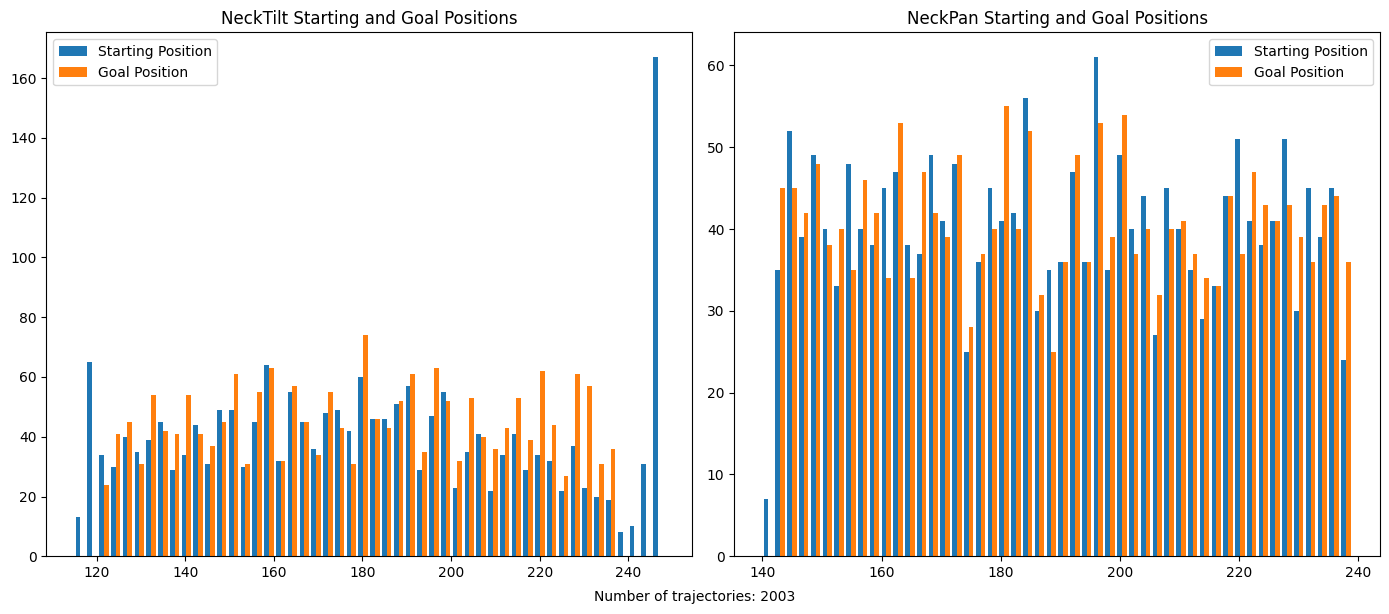

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for NeckTilt
starting_positions_tilt = [mapping_metrics[key]['StartingPosition'][servoIndices['NeckTilt']] for key in mapping_metrics]
goal_positions_tilt = [mapping_metrics[key]['GoalPosition'][servoIndices['NeckTilt']] for key in mapping_metrics]
axs[0].hist([starting_positions_tilt, goal_positions_tilt], bins=50, label=['Starting Position', 'Goal Position'])
axs[0].set_title('NeckTilt Starting and Goal Positions')
axs[0].legend()

# Plot for NeckPan
starting_positions_pan = [mapping_metrics[key]['StartingPosition'][servoIndices['NeckPan']] for key in mapping_metrics]
goal_positions_pan = [mapping_metrics[key]['GoalPosition'][servoIndices['NeckPan']] for key in mapping_metrics]
axs[1].hist([starting_positions_pan, goal_positions_pan], bins=50, label=['Starting Position', 'Goal Position'])
axs[1].set_title('NeckPan Starting and Goal Positions')
axs[1].legend()

#Text with the number of trajectories
fig.text(0.5, -0.01, f'Number of trajectories: {len(all_trajectories)}', ha='center')

plt.tight_layout()
plt.show()

In [25]:
def calculate_average_min_current(servo, servoIndices, mapping_metrics, ids):
    start_position_averages = {}

    for id in ids:
        # Get the start position and MinCurrentToMoveFromStart for the specified servo
        start_pos = mapping_metrics[id]['StartingPosition'][servoIndices[servo]]
        min_current = mapping_metrics[id]['MinCurrentToMoveFromStart'][servoIndices[servo]]

        # Group values by start position
        if start_pos not in start_position_averages:
            start_position_averages[start_pos] = []
        
        start_position_averages[start_pos].append(min_current)
    
    # Calculate average MinCurrentToMoveFromStart for each start position
    for start_pos in start_position_averages:
        start_position_averages[start_pos] = np.mean(start_position_averages[start_pos])

    return start_position_averages


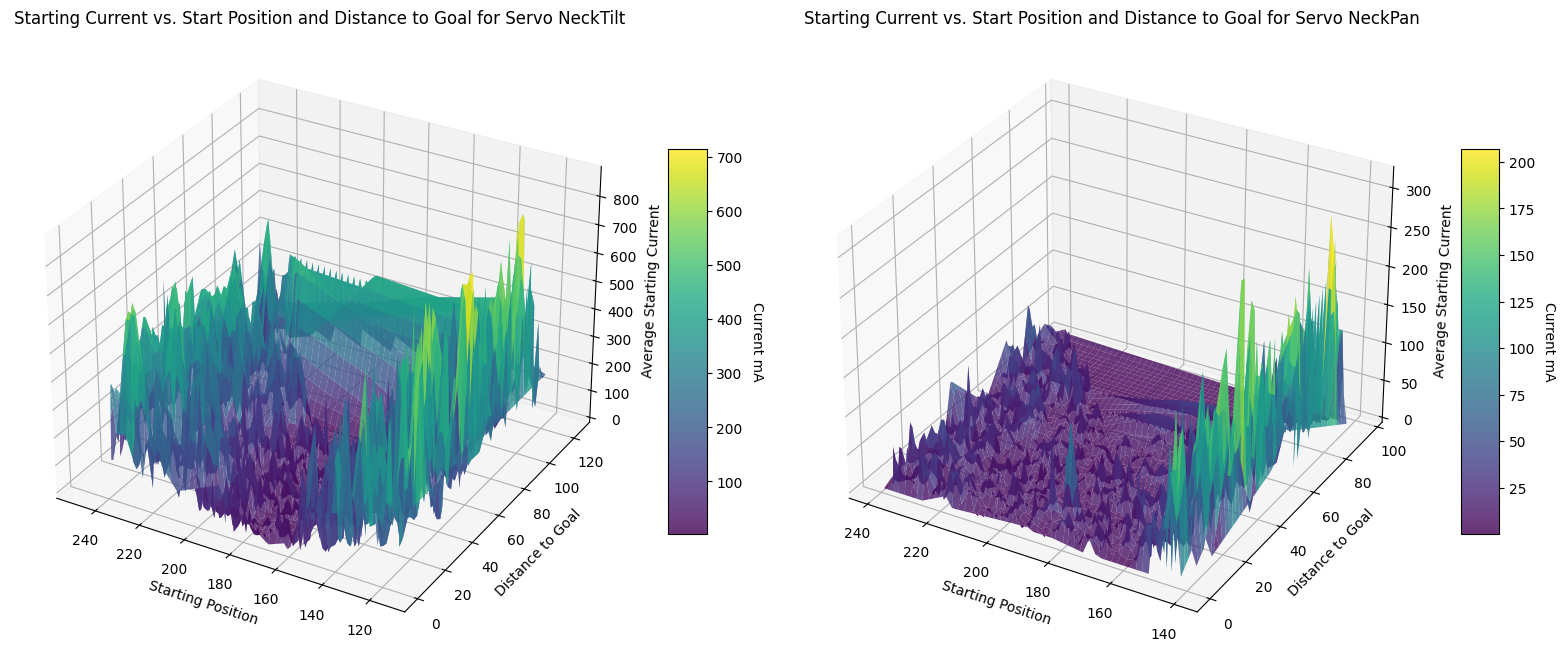

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_start_current_vs_distance(data, servos, servo_indices, ids):
    fig, axs = plt.subplots(1, len(servos), figsize=(16, 8), subplot_kw={'projection': '3d'})

    for i, servo in enumerate(servos):
        start_positions = []
        distances_to_goal = []
        starting_currents = []

        for id in ids:
            # Retrieve starting and goal positions
            start_pos = data[id]["StartingPosition"][servo_indices[servo]]
            goal_pos = data[id]["GoalPosition"][servo_indices[servo]]

            
            # Calculate distance to goal
            distance_to_goal = abs(goal_pos - start_pos)
            
            # Retrieve MinCurrentToMoveFromStart
            min_current = data[id]["MinCurrentToMoveFromStart"][servo_indices[servo]]
            min_torque_current = data[id]["MinCurrentForTorqueAtGoal"][servo_indices[servo]]
            
            # Store values
            start_positions.append(start_pos)
            distances_to_goal.append(distance_to_goal)
            starting_currents.append(min_current)
        
        # Create a grid for smooth surface plotting
        xi = np.linspace(min(start_positions), max(start_positions), 100)
        yi = np.linspace(min(distances_to_goal), max(distances_to_goal), 100)
        xi, yi = np.meshgrid(xi, yi)
        zi = griddata((start_positions, distances_to_goal), starting_currents, (xi, yi), method='linear')

        # Plotting
        ax = axs[i]
        surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)
        # Add shading for depth effect
        surf._facecolors2d = surf._facecolor3d
        surf._edgecolors2d = surf._edgecolor3d

        # Add color bar
        color_bar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        color_bar.set_label('Current mA', rotation=270, labelpad=15)
        
        # Labels and title
        ax.set_xlabel('Starting Position')
        ax.set_ylabel('Distance to Goal')
        ax.set_zlabel('Average Starting Current')
        ax.set_title(f'Starting Current vs. Start Position and Distance to Goal for Servo {servo}')
        
        # Reverse the x-axis
        ax.set_xlim(ax.get_xlim()[::-1])
    
    plt.tight_layout()
    plt.show()

# Usage example
# Servo indices: 0 for tilting servo, 1 for pan servo
plot_start_current_vs_distance(mapping_metrics, ['NeckTilt', 'NeckPan'], servoIndices, mapping_metrics.keys())


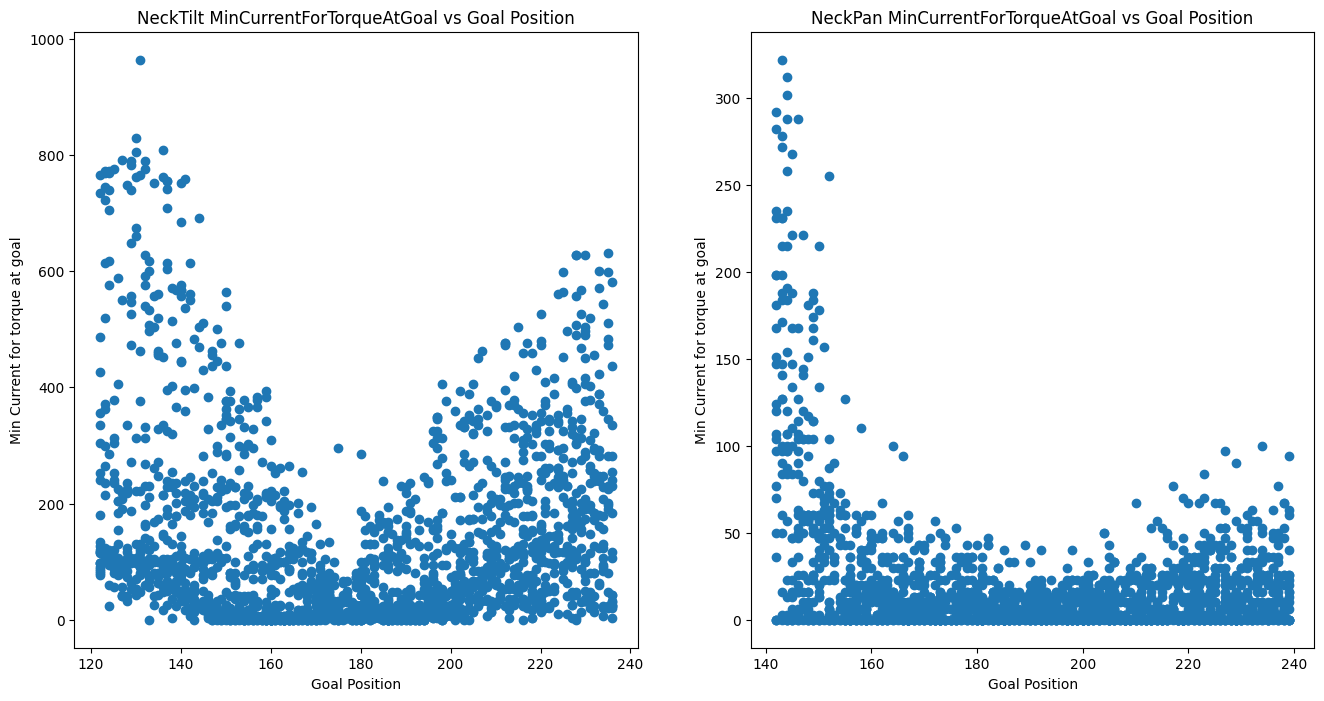

In [27]:
#plot MinCurrentForTorqueAtGoal vs goal position
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i,servo in enumerate(servos_in_use):
    goal_positions = [mapping_metrics[key]['GoalPosition'][servoIndices[servo]] for key in mapping_metrics]
    min_currents = [mapping_metrics[key]['MinCurrentForTorqueAtGoal'][servoIndices[servo]] for key in mapping_metrics]
    axs[i].scatter(goal_positions, min_currents)
    axs[i].set_title(f'{servo} MinCurrentForTorqueAtGoal vs Goal Position')
    axs[i].set_xlabel('Goal Position')
    axs[i].set_ylabel('Min Current for torque at goal')

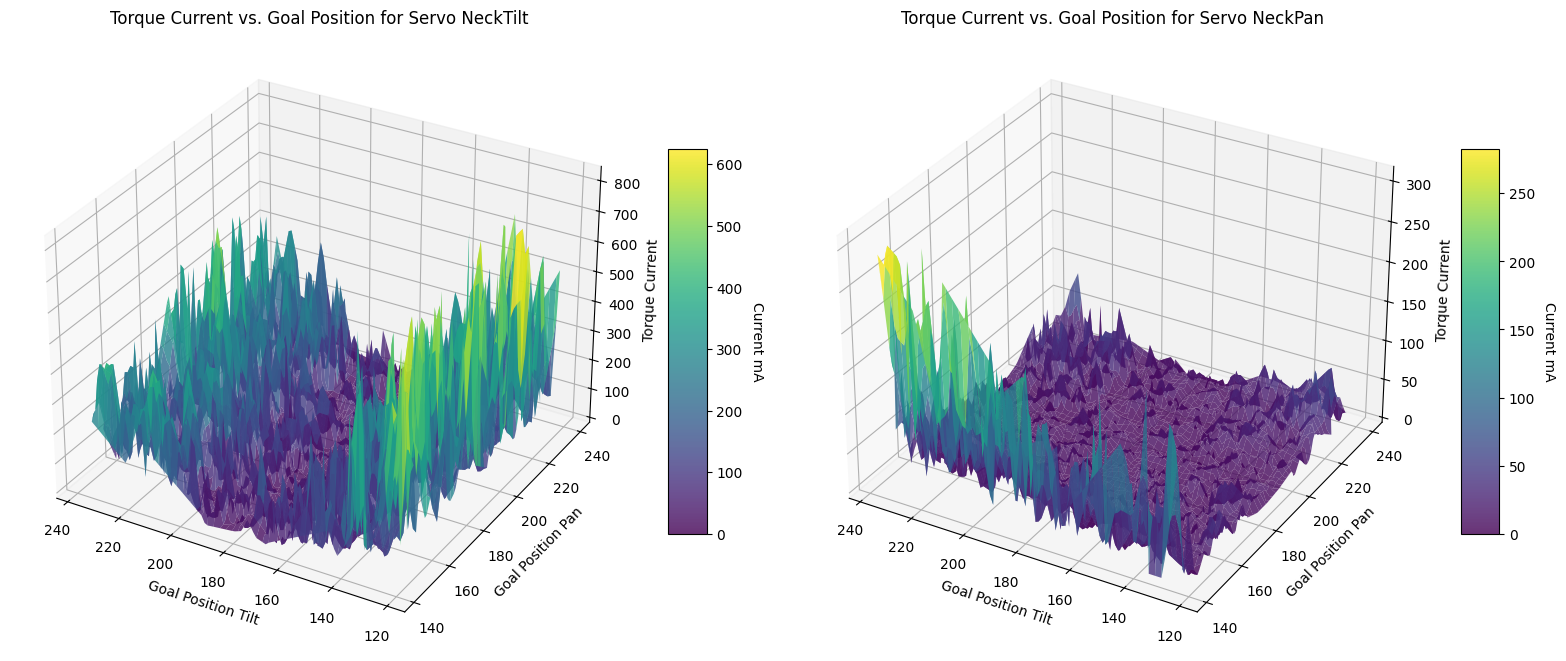

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_torq_current_vs_positions(data, servos, servo_indices, ids):
    fig, axs = plt.subplots(1, len(servos), figsize=(16, 8), subplot_kw={'projection': '3d'})

    for i, servo in enumerate(servos):
        goal_positions_tilt = []
        goal_positions_pan = []
        torqe_currents = []

        for id in ids:
            # Retrieve starting and goal positions
            goal_pos_tilt = data[id]["GoalPosition"][0]
            goal_pos_pan = data[id]["GoalPosition"][1]


            min_torque_current = data[id]["MinCurrentForTorqueAtGoal"][servo_indices[servo]]
            
            # Store values
            goal_positions_tilt.append(goal_pos_tilt)
            goal_positions_pan.append(goal_pos_pan)
            torqe_currents.append(min_torque_current)
        
        # Create a grid for smooth surface plotting
        xi = np.linspace(min(goal_positions_tilt), max(goal_positions_tilt), 100)
        yi = np.linspace(min(goal_positions_pan), max(goal_positions_pan), 100)
        xi, yi = np.meshgrid(xi, yi)
        zi = griddata((goal_positions_tilt, goal_positions_pan), torqe_currents, (xi, yi), method='linear')

        # Plotting
        ax = axs[i]
        surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)
        # Add shading for depth effect
        surf._facecolors2d = surf._facecolor3d
        surf._edgecolors2d = surf._edgecolor3d

        # Add color bar
        color_bar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        color_bar.set_label('Current mA', rotation=270, labelpad=15)
        
        # Labels and title
        ax.set_xlabel('Goal Position Tilt')
        ax.set_ylabel('Goal Position Pan')
        ax.set_zlabel('Torque Current')
        ax.set_title(f'Torque Current vs. Goal Position for Servo {servo}')

        # Reverse the x-axis
        ax.set_xlim(ax.get_xlim()[::-1])
    
    plt.tight_layout()
    plt.show()

# Usage example
# Servo indices: 0 for tilting servo, 1 for pan servo
plot_torq_current_vs_positions(mapping_metrics, ['NeckTilt', 'NeckPan'], servoIndices, mapping_metrics.keys())


In [36]:
from collections import defaultdict
def plot_average_current(current_trace, position_trace, servos):
    fig = plt.figure(figsize=(16, 8))

    for i, servo in enumerate(servos):
        current_data = defaultdict(list)
        x, y, z = [], [], []


        for trajectory in current_trace.keys():
            # Collect data points for starting position and distance to goal
            current_vals = current_trace[trajectory][:, servoIndices[servo]]
            trajectory_vals = position_trace[trajectory][:, servoIndices[servo]]
            goal_pos = trajectory_vals[-1]
            distances_to_goal = np.round(abs(trajectory_vals - goal_pos), 2)



            for pos, dist_to_goal, curr in zip(trajectory_vals, distances_to_goal, current_vals):
                #convert to int to avoid float precision issues
                pos = int(pos)
                dist_to_goal = int(dist_to_goal)
                current_data[(pos, dist_to_goal)].append(curr)


        #display first 5 values of the current data
        if i == 0:
            print(dict(list(current_data.items())[0:5]))

        # Calculate average current for each position and distance to goal
        avg_current_data = {
            (pos, dist): np.mean(currents) for (pos, dist), currents in current_data.items()

        }


        # Prepare data for plotting
        positions = [pos for (pos, dist) in avg_current_data.keys()]
        distances = [dist for (pos, dist) in avg_current_data.keys()]
        avg_currents = [avg_current_data[(pos, dist)] for (pos, dist) in avg_current_data.keys()]


        x.extend(positions)
        y.extend(distances)
        z.extend(avg_currents)

        print(f"Max average current for {servo}: {max(avg_currents)}")
        # Create a grid for the surface plot
        xi, yi = np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100)
        xi, yi = np.meshgrid(xi, yi)
        zi = griddata((x, y), z, (xi, yi), method='linear')


        # Create a 3D subplot for each servo
        ax = fig.add_subplot(1, len(servos), i + 1, projection='3d')
        surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
        

        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Average Current (mA)')



        ax.set_xlabel('Positions')
        ax.set_ylabel('Distance to Goal Position')
        ax.set_zlabel('Average Current')
        ax.set_title(f'Topographical Map of Average Current for {servo}')

        # Reverse the x-axis
        ax.set_xlim(ax.get_xlim()[::-1])



    plt.tight_layout()

    plt.show()


{(176, 17): [0.0, 0.0, 23.52, 26.88, 26.88, 30.24, 33.6, 36.96, 36.96, 40.32, 40.32, 47.04, 43.68, 43.68, 43.68, 73.92, 40.32, 26.88, 90.72, 47.04, 47.04, 60.48, 33.6, 73.92, 77.28, 80.64, 73.92, 63.84, 33.6, 63.84], (175, 17): [50.4, 50.4, 47.04, 30.24, 50.4, 36.96, 26.88, 43.68, 80.64, 70.56, 117.6, 53.76, 26.88, 23.52, 33.6, 47.04, 84.0, 120.96, 70.56], (175, 16): [53.76, 50.4, 53.76, 50.4, 47.04, 50.4, 50.4, 53.76, 57.12, 53.76, 47.04, 104.16, 47.04, 63.84, 23.52, 67.2, 53.76, 50.4, 3.36, 23.52, 26.88, 36.96, 154.56, 100.8, 77.28, 77.28, 33.6, 110.88, 13.44, 3.36, 100.8], (174, 16): [60.48, 53.76, 63.84, 16.8, 10.08, 33.6, 114.24, 20.16, 63.84, 23.52, 154.56, 36.96, 107.52, 80.64, 114.24, 26.88, 26.88, 26.88, 67.2, 13.44, 84.0, 73.92, 30.24, 57.12, 50.4, 47.04], (174, 15): [57.12, 60.48, 60.48, 63.84, 60.48, 63.84, 47.04, 36.96, 40.32, 13.44, 23.52, 3.36, 10.08, 26.88, 30.24, 30.24, 77.28, 77.28, 84.0, 73.92, 33.6]}
Max average current for NeckTilt: 1190.2705494505494
Max average c

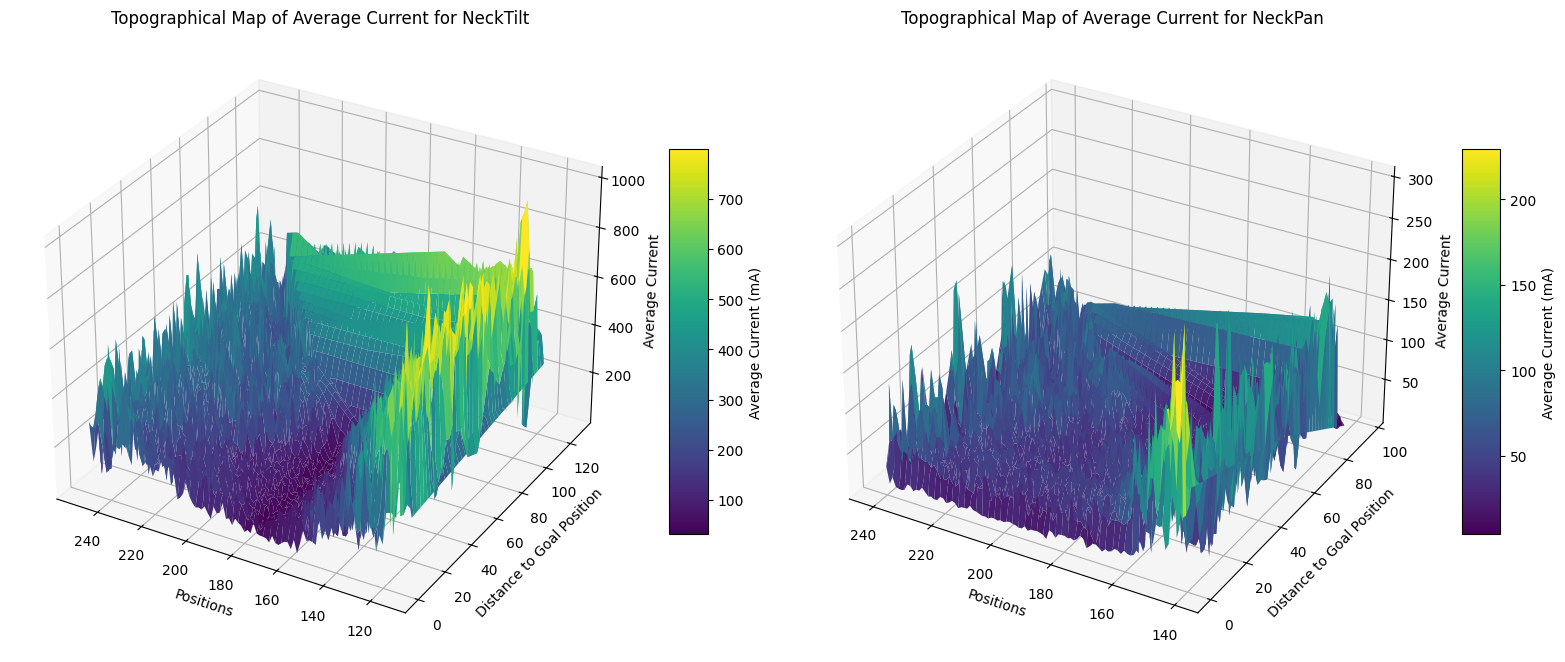

In [30]:
plot_average_current(all_currents, all_trajectories, ['NeckTilt', 'NeckPan'])

In [37]:
#max value of current of all the keys current for each servo
max_currents = {servo: max([np.max(all_currents[key][:, servoIndices[servo]]) for key in all_currents.keys()]) for servo in servos_in_use}
print(f"Max currents: {max_currents}")

max_x_angles = {servo: max([np.max(all_angles[key][:, 0]) for key in all_angles.keys()]) for servo in servos_in_use}
max_y_angles = {servo: max([np.max(all_angles[key][:, 1]) for key in all_angles.keys()]) for servo in servos_in_use}
max_z_angles = {servo: max([np.max(all_angles[key][:, 2]) for key in all_angles.keys()]) for servo in servos_in_use}
print(f"Max X angles: {max_x_angles}")
print(f"Max Y angles: {max_y_angles}")
print(f"Max Z angles: {max_z_angles}")

max_positions = {servo: max([np.max(all_trajectories[key][:, servoIndices[servo]]) for key in all_trajectories.keys()]) for servo in servos_in_use}
min_positions = {servo: min([np.min(all_trajectories[key][:, servoIndices[servo]]) for key in all_trajectories.keys()]) for servo in servos_in_use}
print(f"Max positions: {max_positions}")
print(f"Min positions: {min_positions}")


Max currents: {'NeckTilt': 1229.76, 'NeckPan': 567.84}
Max X angles: {'NeckTilt': 74.05, 'NeckPan': 74.05}
Max Y angles: {'NeckTilt': 73.22, 'NeckPan': 73.22}
Max Z angles: {'NeckTilt': 359.87, 'NeckPan': 359.87}
Max positions: {'NeckTilt': 249.41, 'NeckPan': 241.14}
Min positions: {'NeckTilt': 115.43, 'NeckPan': 140.13}


## Normalised data

In [32]:
normlised_currents = normalise_data(all_currents, servos_in_use)
normlised_trajectories = normalise_data(all_trajectories, servos_in_use)
normlised_gyro = normalise_data(all_gyro, servos_in_use)
normlised_accel = normalise_data(all_accel, servos_in_use)
normlised_angles = normalise_data(all_angles, servos_in_use)